In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/language-detection/Language Detection.csv


In [2]:
!pip install torchinfo tqdm

In [3]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import time
from collections import Counter
import re # For text cleaning
from tqdm.notebook import tqdm
import platform
import psutil
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
cpu_info = platform.processor()
ram_info = psutil.virtual_memory()
total_ram_gb = ram_info.total / (1024 ** 3)
try:
    gpu_info = !nvidia-smi --query-gpu=gpu_name --format=csv
    gpu_name = gpu_info[1]
except:
    gpu_name = "No GPU available"
print("CPU:", cpu_info)
print("Total RAM (GB):", round(total_ram_gb, 2))
print("GPU:", gpu_name)

# Seed Value for reproducibility
seed = 1
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False # Set to True for slightly faster training if not concerned about exact reproducibility

# Device Variable
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

CPU: x86_64
Total RAM (GB): 31.35
GPU: Tesla P100-PCIE-16GB
Using device: cuda


In [5]:
data_path = "/kaggle/input/language-detection/Language Detection.csv"
df = pd.read_csv(data_path)

print("Original DataFrame head:")
print(df.head())
print("\nOriginal DataFrame info:")
df.info()
print("\nLanguage distribution:")
print(df['Language'].value_counts())

Original DataFrame head:
                                                Text Language
0   Nature, in the broadest sense, is the natural...  English
1  "Nature" can refer to the phenomena of the phy...  English
2  The study of nature is a large, if not the onl...  English
3  Although humans are part of nature, human acti...  English
4  [1] The word nature is borrowed from the Old F...  English

Original DataFrame info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10337 entries, 0 to 10336
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Text      10337 non-null  object
 1   Language  10337 non-null  object
dtypes: object(2)
memory usage: 161.6+ KB

Language distribution:
Language
English       1385
French        1014
Spanish        819
Portugeese     739
Italian        698
Russian        692
Sweedish       676
Malayalam      594
Dutch          546
Arabic         536
Turkish        474
German         470
Tamil         

In [6]:
df.isnull().sum()

Text        0
Language    0
dtype: int64

In [7]:
# Function to clean and normalize text
def clean_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove non-alphabet characters (numbers, punctuations, symbols)
    text = re.sub(r'[^a-z\s]', '', text)
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Apply cleaning to the 'Text' column
tqdm.pandas(desc="Cleaning text")
df['Cleaned_Text'] = df['Text'].progress_apply(clean_text)

# Display sample cleaned data
print("\nCleaned Text Examples:")
print(df[['Text', 'Cleaned_Text']].head())

Cleaning text:   0%|          | 0/10337 [00:00<?, ?it/s]


Cleaned Text Examples:
                                                Text  \
0   Nature, in the broadest sense, is the natural...   
1  "Nature" can refer to the phenomena of the phy...   
2  The study of nature is a large, if not the onl...   
3  Although humans are part of nature, human acti...   
4  [1] The word nature is borrowed from the Old F...   

                                        Cleaned_Text  
0  nature in the broadest sense is the natural ph...  
1  nature can refer to the phenomena of the physi...  
2  the study of nature is a large if not the only...  
3  although humans are part of nature human activ...  
4  the word nature is borrowed from the old frenc...  


In [8]:
from collections import defaultdict
import torch

# Tokenize the cleaned text (simple whitespace split)
df['Tokens'] = df['Cleaned_Text'].apply(lambda x: x.split())

# Build vocabulary
word_freq = defaultdict(int)
for tokens in df['Tokens']:
    for token in tokens:
        word_freq[token] += 1

# Create word2idx mapping with special tokens
vocab = {"<PAD>": 0, "<UNK>": 1}
for word in word_freq:
    if word not in vocab:
        vocab[word] = len(vocab)

# Convert tokens to integer sequences
def tokens_to_ids(tokens, vocab):
    return [vocab.get(token, vocab["<UNK>"]) for token in tokens]

df['Input_Ids'] = df['Tokens'].apply(lambda x: tokens_to_ids(x, vocab))

# Define padding function
def pad_sequence(seq, max_len, pad_value=0):
    if len(seq) < max_len:
        return seq + [pad_value] * (max_len - len(seq))
    else:
        return seq[:max_len]

# Decide a max sequence length (e.g., 20 tokens)
MAX_LEN = 20
df['Padded_Ids'] = df['Input_Ids'].apply(lambda x: pad_sequence(x, MAX_LEN))

# Convert to torch tensors
inputs_tensor = torch.tensor(df['Padded_Ids'].tolist())

print("\nExample tokenized and padded sequence:")
print("Original:", df['Tokens'].iloc[0])
print("Token IDs:", df['Input_Ids'].iloc[0])
print("Padded:", df['Padded_Ids'].iloc[0])


Example tokenized and padded sequence:
Original: ['nature', 'in', 'the', 'broadest', 'sense', 'is', 'the', 'natural', 'physical', 'material', 'world', 'or', 'universe']
Token IDs: [2, 3, 4, 5, 6, 7, 4, 8, 9, 10, 11, 12, 13]
Padded: [2, 3, 4, 5, 6, 7, 4, 8, 9, 10, 11, 12, 13, 0, 0, 0, 0, 0, 0, 0]


In [9]:
from sklearn.preprocessing import LabelEncoder

# Encode labels
label_encoder = LabelEncoder()
df['Label'] = label_encoder.fit_transform(df['Language'])

# Final label tensor
labels_tensor = torch.tensor(df['Label'].tolist())

# For reference: map encoded labels to actual languages
label_map = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("\nLabel mapping:")
print(label_map)


Label mapping:
{'Arabic': 0, 'Danish': 1, 'Dutch': 2, 'English': 3, 'French': 4, 'German': 5, 'Greek': 6, 'Hindi': 7, 'Italian': 8, 'Kannada': 9, 'Malayalam': 10, 'Portugeese': 11, 'Russian': 12, 'Spanish': 13, 'Sweedish': 14, 'Tamil': 15, 'Turkish': 16}


In [10]:
X_train_val, X_test, y_train_val, y_test = train_test_split(
    inputs_tensor, labels_tensor, test_size=0.15, random_state=42, stratify=labels_tensor
)

# Then, split train+validation into train and validation
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.176, random_state=42, stratify=y_train_val
) # 0.176 * (1 - 0.15) approx 0.15 of total data

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")
print(f"Test data shape: {X_test.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Validation labels shape: {y_val.shape}")
print(f"Test labels shape: {y_test.shape}")

Training data shape: torch.Size([7239, 20])
Validation data shape: torch.Size([1547, 20])
Test data shape: torch.Size([1551, 20])
Training labels shape: torch.Size([7239])
Validation labels shape: torch.Size([1547])
Test labels shape: torch.Size([1551])


Using device: cuda
Starting training...


Training:   0%|          | 0/114 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0.0m 2s
	Train Loss: 2.137 | Train Acc: 24.30%
	 Val. Loss: 1.661 |  Val. Acc: 38.66%
	Saved best model.


Training:   0%|          | 0/114 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0.0m 1s
	Train Loss: 1.544 | Train Acc: 43.25%
	 Val. Loss: 1.177 |  Val. Acc: 57.14%
	Saved best model.


Training:   0%|          | 0/114 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 0.0m 1s
	Train Loss: 1.231 | Train Acc: 54.80%
	 Val. Loss: 0.968 |  Val. Acc: 63.41%
	Saved best model.


Training:   0%|          | 0/114 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0.0m 1s
	Train Loss: 1.099 | Train Acc: 59.84%
	 Val. Loss: 0.911 |  Val. Acc: 65.61%
	Saved best model.


Training:   0%|          | 0/114 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 0.0m 1s
	Train Loss: 1.002 | Train Acc: 62.65%
	 Val. Loss: 0.859 |  Val. Acc: 68.13%
	Saved best model.


Training:   0%|          | 0/114 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0.0m 1s
	Train Loss: 0.964 | Train Acc: 64.15%
	 Val. Loss: 0.866 |  Val. Acc: 67.81%


Training:   0%|          | 0/114 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 0.0m 1s
	Train Loss: 0.903 | Train Acc: 65.63%
	 Val. Loss: 0.813 |  Val. Acc: 68.58%
	Saved best model.


Training:   0%|          | 0/114 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0.0m 1s
	Train Loss: 0.869 | Train Acc: 67.26%
	 Val. Loss: 0.791 |  Val. Acc: 69.04%
	Saved best model.


Training:   0%|          | 0/114 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 0.0m 1s
	Train Loss: 0.852 | Train Acc: 67.69%
	 Val. Loss: 0.766 |  Val. Acc: 70.52%
	Saved best model.


Training:   0%|          | 0/114 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0.0m 1s
	Train Loss: 0.812 | Train Acc: 68.45%
	 Val. Loss: 0.776 |  Val. Acc: 70.39%

Evaluating on test set...


Evaluating:   0%|          | 0/25 [00:00<?, ?it/s]

Test Loss: 0.760 | Test Acc: 70.02%

Classification Report:
              precision    recall  f1-score   support

      Arabic       0.00      0.00      0.00        80
      Danish       0.95      0.83      0.88        64
       Dutch       0.91      0.90      0.91        82
     English       0.92      0.95      0.94       208
      French       0.91      0.95      0.93       152
      German       0.92      0.94      0.93        71
       Greek       0.00      0.00      0.00        55
       Hindi       0.00      0.00      0.00        10
     Italian       0.91      0.89      0.90       105
     Kannada       0.00      0.00      0.00        55
   Malayalam       0.00      0.00      0.00        89
  Portugeese       0.93      0.92      0.92       111
     Russian       0.20      0.90      0.33       104
     Spanish       0.92      0.93      0.93       123
    Sweedish       0.92      0.95      0.94       101
       Tamil       0.00      0.00      0.00        70
     Turkish       0.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


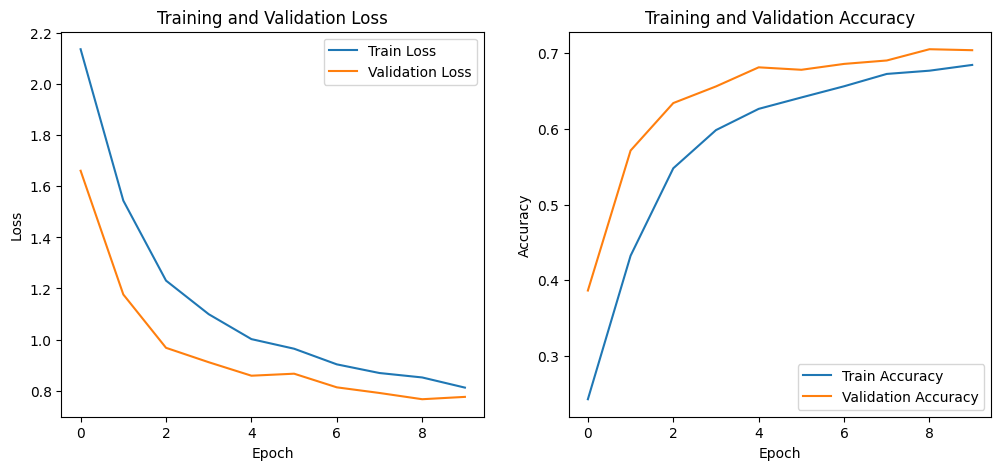

In [11]:
class LanguageDetectionModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, num_layers, dropout=0.5):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        # Using LSTM for potentially better sequence modeling than simple RNN
        self.rnn = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers,
                           bidirectional=True, dropout=dropout, batch_first=True)
        # Use dropout for regularization
        self.dropout = nn.Dropout(dropout)
        # Output layer mapping from hidden state (concatenated for bidirectional) to output classes
        self.fc = nn.Linear(hidden_dim * 2, output_dim)

    def forward(self, text):
        # text = [batch size, seq len]

        embedded = self.dropout(self.embedding(text))
        # embedded = [batch size, seq len, embedding dim]

        output, (hidden, cell) = self.rnn(embedded)
        # output = [batch size, seq len, hid dim * num directions]
        # hidden = [num layers * num directions, batch size, hid dim]
        # cell = [num layers * num directions, batch size, hid dim]

        # We take the hidden state from the last timestep of the last layer
        # For bidirectional RNN, concatenate the forward and backward hidden states
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
        # hidden = [batch size, hid dim * num directions]

        output = self.fc(hidden)
        # output = [batch size, output dim]

        return output

# Model parameters
VOCAB_SIZE = len(vocab)
EMBEDDING_DIM = 100 # Can be adjusted
HIDDEN_DIM = 256    # Can be adjusted
OUTPUT_DIM = len(label_encoder.classes_)
NUM_LAYERS = 2      # Can be adjusted, 2 is often a good starting point
DROPOUT = 0.6       # Increased dropout for more regularization

model = LanguageDetectionModel(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, NUM_LAYERS, DROPOUT)

# Define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')
model = model.to(device)

# Define optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # Adam is a good general-purpose optimizer
criterion = nn.CrossEntropyLoss()

# Move tensors to device
X_train = X_train.to(device)
y_train = y_train.to(device)
X_val = X_val.to(device)
y_val = y_val.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

# Create Datasets and DataLoaders
class TextDataset(Dataset):
    def __init__(self, inputs, labels=None):
        self.inputs = inputs
        self.labels = labels

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        if self.labels is None:
            return self.inputs[idx]
        return self.inputs[idx], self.labels[idx]

train_dataset = TextDataset(X_train, y_train)
val_dataset = TextDataset(X_val, y_val)
test_dataset = TextDataset(X_test, y_test) # Not using labels for test during evaluation, but could be included

BATCH_SIZE = 64 # Increased batch size for potentially faster training and better gradient estimates

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

# Training loop
def train(model, loader, optimizer, criterion, device):
    model.train()
    epoch_loss = 0
    correct_predictions = 0
    total_predictions = 0

    for inputs, labels in tqdm(loader, desc="Training"):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        predictions = model(inputs)
        loss = criterion(predictions, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        _, predicted_labels = torch.max(predictions, dim=1)
        total_predictions += labels.size(0)
        correct_predictions += (predicted_labels == labels).sum().item()

    avg_loss = epoch_loss / len(loader)
    accuracy = correct_predictions / total_predictions
    return avg_loss, accuracy

# Evaluation loop
def evaluate(model, loader, criterion, device):
    model.eval()
    epoch_loss = 0
    correct_predictions = 0
    total_predictions = 0
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in tqdm(loader, desc="Evaluating"):
            inputs, labels = inputs.to(device), labels.to(device)

            predictions = model(inputs)
            loss = criterion(predictions, labels)

            epoch_loss += loss.item()
            _, predicted_labels = torch.max(predictions, dim=1)

            all_predictions.extend(predicted_labels.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            total_predictions += labels.size(0)
            correct_predictions += (predicted_labels == labels).sum().item()

    avg_loss = epoch_loss / len(loader)
    accuracy = correct_predictions / total_predictions
    return avg_loss, accuracy, all_predictions, all_labels

# Training the model with validation
N_EPOCHS = 10 # Increased epochs
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

best_val_loss = float('inf')

print("Starting training...")
for epoch in range(N_EPOCHS):
    start_time = time.time()

    train_loss, train_acc = train(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc, _, _ = evaluate(model, val_loader, criterion, device)

    end_time = time.time()
    epoch_mins, epoch_secs = divmod(end_time - start_time, 60)

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs:.0f}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {val_loss:.3f} |  Val. Acc: {val_acc*100:.2f}%')

    # Save the best model based on validation loss
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pt')
        print("\tSaved best model.")

# Load the best model for evaluation
model.load_state_dict(torch.load('best_model.pt'))

# Evaluate on the test set
print("\nEvaluating on test set...")
test_loss, test_acc, test_predictions, test_labels = evaluate(model, test_loader, criterion, device)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

# Print classification report
print("\nClassification Report:")
print(classification_report(test_labels, test_predictions, target_names=label_encoder.classes_))

# Plot training history
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()